In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from rdkit.Chem import AllChem, MolFromSmiles
from rdkit.DataStructs import ConvertToNumpyArray

In [31]:
# 加载数据
data = pd.read_csv(r'D:\分类数据\去重催化分类内部数据集.csv', encoding='gbk')



In [32]:
# data = pd.read_excel(r'C:\Users\RANSHAO\Untitled Folder\data\去重空白多亚型4.xlsx')

In [33]:
# 打印列名
print(data.columns)

Index(['smiles', 'labels'], dtype='object')


In [34]:
smiles = data['smiles']

In [35]:
print(smiles.head())

0    COc1ncc-2cc1NS(=O)(=O)c1cccc(c1)C(=O)NCc1cccc(...
1    COc1ncc-2cc1NS(=O)(=O)c1cccc(c1)C(=O)NCCn1cc(c...
2    C[C@@H](C1CC1)N1Cc2cc(cc(c2C1=O)S(C)(=O)=O)-c1...
3    CNC(=O)CCNc1nc(nc(n1)-n1c(nc2ccccc12)C(F)F)N1C...
4    OCc1ccc(cc1S(=O)c1nc(cs1)-c1cnc2ccc(Cl)cn12)[N...
Name: smiles, dtype: object


In [36]:
# 标签编码
def encode_labels(labels):
    selective_map = {'α': 0, 'β': 1, 'γ': 2, 'δ': 3}
    non_selective_map = {
        'βδ': [0, 1, 0, 1],
        'αβγδ': [1, 1, 1, 1]
    }
    selective_labels = []
    multi_labels = []
    for label in labels:
        if label in selective_map:
            selective_labels.append(selective_map[label])
            multi_labels.append([0, 0, 0, 0])  # 无多任务标签
        else:
            selective_labels.append(4)  # 非选择性
            multi_labels.append(non_selective_map[label])
    return np.array(selective_labels), np.array(multi_labels)

labels = data['labels']
selective_labels, multi_labels = encode_labels(labels)



In [37]:
from rdkit import Chem
def smiles_to_features(smiles_list):
    features = []
    for smi in smiles_list:
        # 跳过无效的 SMILES（例如 NaN 或 float）
        if isinstance(smi, str):
            mol = Chem.MolFromSmiles(smi)
            if mol is not None:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                features.append(fp)
            else:
                features.append(np.zeros(2048))  # 对无效的 SMILES 使用零向量
        else:
            features.append(np.zeros(2048))  # 对非字符串值使用零向量
    return np.array(features)


smiles = data['smiles']
fps = smiles_to_features(data['smiles'])
# fps = np.array([smiles_to_fp(s) for s in smiles])

[00:01:31] DEPRECATION WARNING: please use MorganGenerator
[00:01:31] DEPRECATION WARNING: please use MorganGenerator
[00:01:31] DEPRECATION WARNING: please use MorganGenerator
[00:01:31] DEPRECATION WARNING: please use MorganGenerator
[00:01:31] DEPRECATION WARNING: please use MorganGenerator
[00:01:31] DEPRECATION WARNING: please use MorganGenerator
[00:01:31] DEPRECATION WARNING: please use MorganGenerator
[00:01:31] DEPRECATION WARNING: please use MorganGenerator
[00:01:31] DEPRECATION WARNING: please use MorganGenerator
[00:01:31] DEPRECATION WARNING: please use MorganGenerator
[00:01:31] DEPRECATION WARNING: please use MorganGenerator
[00:01:31] DEPRECATION WARNING: please use MorganGenerator
[00:01:31] DEPRECATION WARNING: please use MorganGenerator
[00:01:31] DEPRECATION WARNING: please use MorganGenerator
[00:01:31] DEPRECATION WARNING: please use MorganGenerator
[00:01:31] DEPRECATION WARNING: please use MorganGenerator
[00:01:31] DEPRECATION WARNING: please use MorganGenerat

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from torch.nn.functional import one_hot

# 数据划分
X_train, X_test, y_sel_train, y_sel_test, y_multi_train, y_multi_test = train_test_split(
    fps, selective_labels, multi_labels, test_size=0.2, random_state=42
)


In [39]:
# 特征标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
# 定义 Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=7, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [41]:
# 构建更复杂的多任务模型
class AdvancedMultiTaskMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AdvancedMultiTaskMLP, self).__init__()
        # 增加网络深度和宽度
        self.shared_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.7),  # 减少dropout比例
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Dropout(0.7),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.7),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(0.7)
        )
        self.selective_head = nn.Linear(hidden_dim // 2, 5)  # 5个选择性类别
        self.multi_head = nn.Linear(hidden_dim // 2, 4)  # 4个多任务输出

    def forward(self, x):
        shared = self.shared_layer(x)
        selective_out = self.selective_head(shared)
        multi_out = torch.sigmoid(self.multi_head(shared))
        return selective_out, multi_out

In [42]:
# 模型实例化
model = AdvancedMultiTaskMLP(input_dim=2048, hidden_dim=1024)
criterion_selective = FocalLoss(alpha=1, gamma=7)
criterion_multi = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=5e-4)



In [43]:
# 训练模型
num_epochs = 500
early_stop_patience = 10
best_loss = float('inf')
no_improve_epochs = 0

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_sel_train_tensor = torch.tensor(y_sel_train, dtype=torch.long)
    y_multi_train_tensor = torch.tensor(y_multi_train, dtype=torch.float32)

    sel_out, multi_out = model(X_train_tensor)
    loss_sel = criterion_selective(sel_out, y_sel_train_tensor)
    loss_multi = criterion_multi(multi_out, y_multi_train_tensor)
    loss = 0.7 * loss_sel + 0.3 * loss_multi

    loss.backward()
    optimizer.step()
    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    if loss < best_loss:
        best_loss = loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improve_epochs += 1

    if no_improve_epochs >= early_stop_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 加载最佳模型
model.load_state_dict(torch.load('best_model.pth'))

Epoch 1/500, Loss: 0.9285329580307007
Epoch 2/500, Loss: 0.9240478277206421
Epoch 3/500, Loss: 0.9040318131446838
Epoch 4/500, Loss: 0.8862800598144531
Epoch 5/500, Loss: 0.8643006682395935
Epoch 6/500, Loss: 0.8371211290359497
Epoch 7/500, Loss: 0.8163848519325256
Epoch 8/500, Loss: 0.7827629446983337
Epoch 9/500, Loss: 0.7330568432807922
Epoch 10/500, Loss: 0.6943214535713196
Epoch 11/500, Loss: 0.6487245559692383
Epoch 12/500, Loss: 0.5925290584564209
Epoch 13/500, Loss: 0.5575758218765259
Epoch 14/500, Loss: 0.516896665096283
Epoch 15/500, Loss: 0.4788256883621216
Epoch 16/500, Loss: 0.45935094356536865
Epoch 17/500, Loss: 0.4364732503890991
Epoch 18/500, Loss: 0.43076029419898987
Epoch 19/500, Loss: 0.4206095337867737
Epoch 20/500, Loss: 0.4102818965911865
Epoch 21/500, Loss: 0.4054926633834839
Epoch 22/500, Loss: 0.4000861644744873
Epoch 23/500, Loss: 0.39744848012924194
Epoch 24/500, Loss: 0.3895404636859894
Epoch 25/500, Loss: 0.380831778049469
Epoch 26/500, Loss: 0.37019991874

C:\Users\RANSHAO\AppData\Local\Temp\ipykernel_16024\4244695747.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [44]:
# 测试与评估
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_sel_test_tensor = torch.tensor(y_sel_test, dtype=torch.long)
y_multi_test_tensor = torch.tensor(y_multi_test, dtype=torch.float32)

with torch.no_grad():
    sel_out, multi_out = model(X_test_tensor)
    sel_pred = torch.argmax(sel_out, dim=1).numpy()
    multi_pred = (multi_out.numpy() > 0.5).astype(int)

In [ ]:
from sklearn.metrics import classification_report

# 假设已经完成了数据加载和预处理，并且划分了训练集和测试集
# X_train, X_test, y_train, y_test = ...

# 训练模型 (这是一个示例，根据实际情况替换)
# model.fit(X_train, y_train)

# 预测测试集
sel_pred = model.predict(X_sel_test)

# 生成分类报告
target_names = ['α', 'β', 'γ', 'δ', 'Non-selective']
report = classification_report(y_sel_test, sel_pred, target_names=target_names, output_dict=True)

# 格式化打印分类报告...
# （这里是你的原始代码部分，不需要修改）

In [45]:

# 打印分类报告，设置输出字典
target_names = ['α', 'β', 'γ', 'δ', 'Non-selective']
report = classification_report(y_sel_test, sel_pred, target_names=target_names, output_dict=True)

# 格式化打印分类报告，确保 accuracy 显示为4位有效数字
report_str = f"""
Classification Report:
{'-'*40}
Category          Precision   Recall   F1-Score   Support
"""
for label, metrics in report.items():
    if label not in ['accuracy', 'macro avg', 'weighted avg']:
        report_str += f"{label:<16} {metrics['precision']:.4f}   {metrics['recall']:.4f}   {metrics['f1-score']:.4f}   {int(metrics['support']):<8}\n"

# 添加 accuracy 和其他平均指标
accuracy = report["accuracy"]
macro_avg = report["macro avg"]
weighted_avg = report["weighted avg"]
report_str += f"""
{'-'*40}
Accuracy:         {accuracy:.4f}
Macro Avg         {macro_avg['precision']:.4f}   {macro_avg['recall']:.4f}   {macro_avg['f1-score']:.4f}
Weighted Avg      {weighted_avg['precision']:.4f}   {weighted_avg['recall']:.4f}   {weighted_avg['f1-score']:.4f}
"""

print(report_str)



Classification Report:
----------------------------------------
Category          Precision   Recall   F1-Score   Support
α                0.9259   0.9701   0.9475   1571    
β                0.9091   0.5455   0.6818   55      
γ                0.8390   0.6875   0.7557   144     
δ                0.9571   0.9360   0.9464   1312    
Non-selective    0.9175   0.9368   0.9271   95      

----------------------------------------
Accuracy:         0.9348
Macro Avg         0.9097   0.8152   0.8517
Weighted Avg      0.9343   0.9348   0.9331



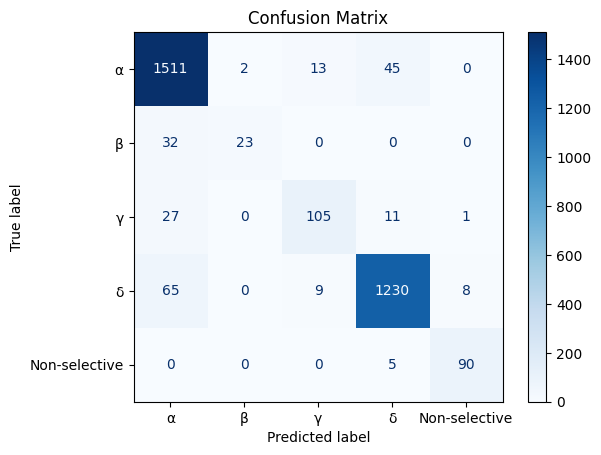

In [21]:
# 绘制混淆矩阵
cm = confusion_matrix(y_sel_test, sel_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix

# 假设sel_out是经过softmax处理的输出，shape为(n_samples, 2)
# y_sel_test_tensor是真实标签，shape为(n_samples,)
# sel_pred是通过torch.argmax(sel_out, dim=1).numpy()得到的预测类别

# 确保sel_out是一个numpy数组，并且我们只取属于正类的概率
y_scores = sel_out.numpy()[:, 1] # 对于二分类问题，取第二个输出作为概率

# 计算AUC和绘制AUC曲线
fpr, tpr, _ = roc_curve(y_sel_test_tensor.numpy(), y_scores) # 使用真实标签和预测概率
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('auc_curve.png') # 保存图像

# 保存AUC曲线数据为CSV文件
auc_data = {'False Positive Rate': fpr, 'True Positive Rate': tpr}
df_auc = pd.DataFrame(auc_data)
df_auc.to_csv('auc_data.csv', index=False)

# 混淆矩阵
cm = confusion_matrix(y_sel_test_tensor.numpy(), sel_pred)

# 使用Matplotlib绘制混淆矩阵
plt.figure(figsize=(10,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2) # 二分类
plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
plt.yticks(tick_marks, ['Class 0', 'Class 1'])

# 打印数值
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png') # 保存图像

# 保存混淆矩阵为CSV文件
df_cm = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
df_cm.to_csv('confusion_matrix.csv', index=True)

ValueError: multiclass format is not supported

In [22]:
# import pandas as pd
# import numpy as np
# import torch
# from rdkit.Chem import MolFromSmiles, AllChem
# from rdkit.DataStructs import ConvertToNumpyArray
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import LabelBinarizer

# # 加载数据集
# data = pd.read_excel(r'D:\分类数据\0.1外部分类验证集.xlsx')

# # 定义亚型标签映射
# selective_map = {'α': 0, 'β': 1, 'γ': 2, 'δ': 3}
# non_selective_map = {
#     'βδ': [0, 1, 0, 1],
#     'αβγδ': [1, 1, 1, 1]
# }

# # SMILES 转分子描述符
# def smiles_to_fp(smiles):
#     mol = MolFromSmiles(smiles)
#     if mol is not None:
#         fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
#         arr = np.zeros((2048,), dtype=int)
#         ConvertToNumpyArray(fp, arr)
#         return arr
#     else:
#         return None

# # 批量处理 SMILES
# def batch_smiles_to_fp(smiles_list):
#     fps = []
#     valid_indices = []
#     for i, smile in enumerate(smiles_list):
#         fp = smiles_to_fp(smile)
#         if fp is not None:
#             fps.append(fp)
#             valid_indices.append(i)
#         else:
#             print(f"Invalid SMILES at index {i}: {smile}")
#     return np.array(fps), valid_indices

# # 提取 SMILES 并生成指纹
# smiles_list = data['smiles'].tolist()
# fps, valid_indices = batch_smiles_to_fp(smiles_list)

# # 标准化特征
# scaler = StandardScaler()
# fps_scaled = scaler.fit_transform(fps)

# # 转换为张量
# fps_tensor = torch.tensor(fps_scaled, dtype=torch.float32)

# # 模型推理
# model.eval()
# with torch.no_grad():
#     sel_out, multi_out = model(fps_tensor)
#     sel_pred = torch.argmax(sel_out, dim=1).numpy()
#     multi_pred = (multi_out.numpy() > 0.5).astype(int)

# # 构建预测结果并比对标签
# true_labels = []
# pred_labels = []
# results = []

# for i, idx in enumerate(valid_indices):
#     smile = smiles_list[idx]
#     true_label = data.iloc[idx]['labels']
    
#     # 模型预测
#     if sel_pred[i] < 4:  # 选择性抑制剂
#         predicted_label = list(selective_map.keys())[sel_pred[i]]
#     else:  # 非选择性抑制剂
#         predicted_label = ''.join([subtype for subtype, is_present in zip(['α', 'β', 'γ', 'δ'], multi_pred[i]) if is_present])
    
#     # 比对真实值和预测值
#     true_labels.append(true_label)
#     pred_labels.append(predicted_label)
    
#     results.append({
#         'SMILES': smile,
#         'True Label': true_label,
#         'Predicted Label': predicted_label,
#     })

# # 准确率
# accuracy = accuracy_score(true_labels, pred_labels)
# print(f"Overall Accuracy: {accuracy:.4f}")

# # 分类报告
# print("Classification Report:")
# print(classification_report(true_labels, pred_labels))

# # 混淆矩阵
# conf_matrix = confusion_matrix(true_labels, pred_labels)
# print("Confusion Matrix:")
# print(conf_matrix)

# # 使用LabelBinarizer来处理多分类问题
# lb = LabelBinarizer()
# true_labels_bin = lb.fit_transform(true_labels)

# # 模型的预测概率（用于计算AUC）
# y_prob = multi_out.numpy()

# # 绘制ROC曲线
# plt.figure(figsize=(10, 8))
# n_classes = y_prob.shape[1]
# fpr, tpr, roc_auc = {}, {}, {}

# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], y_prob[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # 保存ROC曲线数据到CSV文件
# roc_data = []
# for i in range(n_classes):
#     for j in range(len(fpr[i])):
#         roc_data.append({
#             'Class': lb.classes_[i],
#             'False Positive Rate': fpr[i][j],
#             'True Positive Rate': tpr[i][j],
#             'AUC': roc_auc[i]
#         })

# roc_df = pd.DataFrame(roc_data)
# roc_df.to_csv(r'D:\分类数据\多层感知机验证集_roc_curve_data.csv', index=False)

# print("ROC curve data saved to r'D:\分类数据\roc_curve_data.csv")

# # 绘制ROC曲线
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     plt.plot(fpr[i], tpr[i], label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# # 画对角线（随机分类器的ROC曲线）
# plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# # 设置图形属性
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve (AUC) for Multi-Class Classification')
# plt.legend(loc='lower right')

# # 显示AUC曲线图
# plt.show()

# # 保存结果到 CSV 文件
# results_df = pd.DataFrame(results)
# results_df.to_excel(r'D:\分类数据\感知机推理能力.xlsx', index=False)

# print("Predictions saved to r'D:\分类数据\感知机推理能力.xlsx")

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# 创建保存目录
save_dir = "AUC_and_ConfusionMatrix"
os.makedirs(save_dir, exist_ok=True)

# 定义绘图和保存函数
def plot_and_save_roc_curve(y_true, y_scores, dataset_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # 绘制 AUC 曲线
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({dataset_name})')
    plt.legend(loc='lower right')
    
    # 保存 AUC 曲线图
    plt.savefig(f"{save_dir}/ROC_Curve_{dataset_name}.png")
    plt.close()
    
    # 保存 AUC 数据到 CSV
    pd.DataFrame({'FPR': fpr, 'TPR': tpr}).to_csv(f"{save_dir}/ROC_Data_{dataset_name}.csv", index=False)

def plot_and_save_confusion_matrix(y_true, y_pred, dataset_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    plt.figure()
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix ({dataset_name})')
    
    # 保存混淆矩阵图像
    plt.savefig(f"{save_dir}/Confusion_Matrix_{dataset_name}.png")
    plt.close()

# 计算并保存 **测试集** AUC & 混淆矩阵
plot_and_save_roc_curve(y_sel_test, y_sel_test_scores, "Test_Set")
plot_and_save_confusion_matrix(y_sel_test, y_sel_test_pred, "Test_Set")

# 计算并保存 **外部验证集** AUC & 混淆矩阵
plot_and_save_roc_curve(y_external, y_external_scores, "External_Validation_Set")
plot_and_save_confusion_matrix(y_external, y_external_pred, "External_Validation_Set")


NameError: name 'y_sel_test_scores' is not defined

[15:20:41] DEPRECATION WARNING: please use MorganGenerator
[15:20:41] DEPRECATION WARNING: please use MorganGenerator
[15:20:41] DEPRECATION WARNING: please use MorganGenerator
[15:20:41] DEPRECATION WARNING: please use MorganGenerator
[15:20:41] DEPRECATION WARNING: please use MorganGenerator
[15:20:41] DEPRECATION WARNING: please use MorganGenerator
[15:20:41] DEPRECATION WARNING: please use MorganGenerator
[15:20:41] DEPRECATION WARNING: please use MorganGenerator
[15:20:41] DEPRECATION WARNING: please use MorganGenerator
[15:20:41] DEPRECATION WARNING: please use MorganGenerator
[15:20:41] DEPRECATION WARNING: please use MorganGenerator
[15:20:41] DEPRECATION WARNING: please use MorganGenerator
[15:20:41] DEPRECATION WARNING: please use MorganGenerator
[15:20:41] DEPRECATION WARNING: please use MorganGenerator
[15:20:41] DEPRECATION WARNING: please use MorganGenerator
[15:20:41] DEPRECATION WARNING: please use MorganGenerator
[15:20:41] DEPRECATION WARNING: please use MorganGenerat

Overall Accuracy: 0.9295
Classification Report:
              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
           α       0.92      0.97      0.94       883
        αβγδ       0.98      1.00      0.99        44
           β       0.75      0.43      0.55        28
          βδ       0.00      0.00      0.00        12
           γ       0.83      0.63      0.71        83
           δ       0.96      0.95      0.96       710

    accuracy                           0.93      1760
   macro avg       0.63      0.57      0.59      1760
weighted avg       0.93      0.93      0.93      1760

Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0 853   0   4   0   8  18]
 [  0   0  44   0   0   0   0]
 [  0  16   0  12   0   0   0]
 [  7   0   0   0   0   0   5]
 [  1  27   0   0   0  52   3]
 [  1  30   1   0   0   3 675]]


E:\anaconda\envs\AIDrugDesign\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\envs\AIDrugDesign\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\envs\AIDrugDesign\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\envs\AIDrugDesign\lib

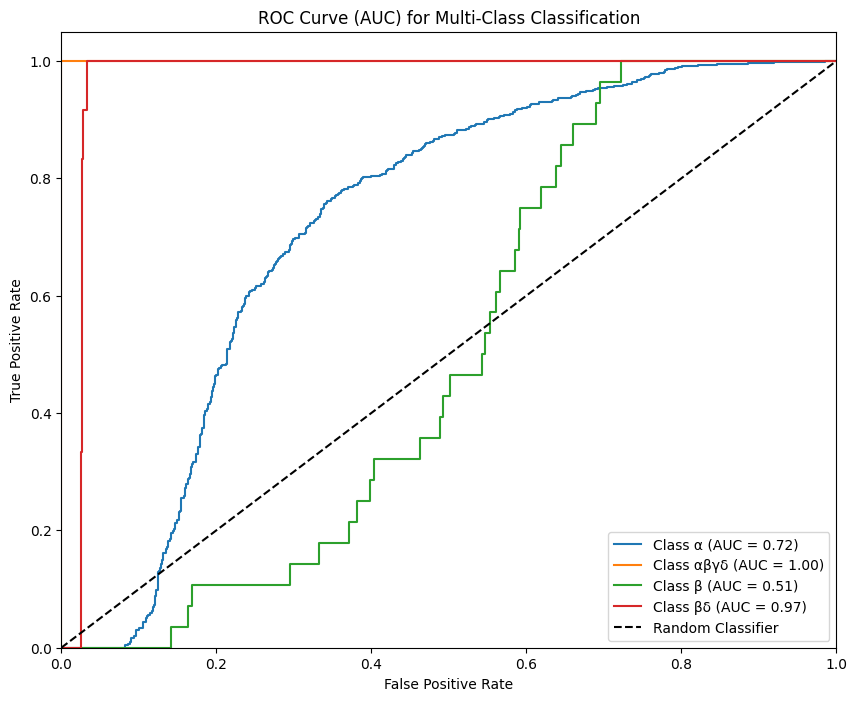

Predictions saved to r'D:\分类数据\感知机推理能力.xlsx


In [75]:
import pandas as pd
import numpy as np
import torch
from rdkit.Chem import MolFromSmiles, AllChem
from rdkit.DataStructs import ConvertToNumpyArray
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# 加载数据集
data = pd.read_excel(r'D:\分类数据\0.1外部分类验证集.xlsx')

# 定义亚型标签映射
selective_map = {'α': 0, 'β': 1, 'γ': 2, 'δ': 3}
non_selective_map = {
    'βδ': [0, 1, 0, 1],
    'αβγδ': [1, 1, 1, 1]
}

# SMILES 转分子描述符
def smiles_to_fp(smiles):
    mol = MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        arr = np.zeros((2048,), dtype=int)
        ConvertToNumpyArray(fp, arr)
        return arr
    else:
        return None

# 批量处理 SMILES
def batch_smiles_to_fp(smiles_list):
    fps = []
    valid_indices = []
    for i, smile in enumerate(smiles_list):
        fp = smiles_to_fp(smile)
        if fp is not None:
            fps.append(fp)
            valid_indices.append(i)
        else:
            print(f"Invalid SMILES at index {i}: {smile}")
    return np.array(fps), valid_indices

# 提取 SMILES 并生成指纹
smiles_list = data['smiles'].tolist()
fps, valid_indices = batch_smiles_to_fp(smiles_list)

# 标准化特征
scaler = StandardScaler()
fps_scaled = scaler.fit_transform(fps)

# 转换为张量
fps_tensor = torch.tensor(fps_scaled, dtype=torch.float32)

# 模型推理
model.eval()
with torch.no_grad():
    sel_out, multi_out = model(fps_tensor)
    sel_pred = torch.argmax(sel_out, dim=1).numpy()
    multi_pred = (multi_out.numpy() > 0.5).astype(int)

# 构建预测结果并比对标签
true_labels = []
pred_labels = []
results = []

for i, idx in enumerate(valid_indices):
    smile = smiles_list[idx]
    true_label = data.iloc[idx]['labels']
    
    # 模型预测
    if sel_pred[i] < 4:  # 选择性抑制剂
        predicted_label = list(selective_map.keys())[sel_pred[i]]
    else:  # 非选择性抑制剂
        predicted_label = ''.join([subtype for subtype, is_present in zip(['α', 'β', 'γ', 'δ'], multi_pred[i]) if is_present])
    
    # 比对真实值和预测值
    true_labels.append(true_label)
    pred_labels.append(predicted_label)
    
    results.append({
        'SMILES': smile,
        'True Label': true_label,
        'Predicted Label': predicted_label,
    })

# 准确率
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Overall Accuracy: {accuracy:.4f}")

# 分类报告
print("Classification Report:")
print(classification_report(true_labels, pred_labels))

# 混淆矩阵
conf_matrix = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

# 绘制AUC曲线
# 使用LabelBinarizer来处理多分类问题
lb = LabelBinarizer()
true_labels_bin = lb.fit_transform(true_labels)

# 模型的预测概率（用于计算AUC）
# multi_out 是每个类别的概率
y_prob = multi_out.numpy()

# 绘制ROC曲线
plt.figure(figsize=(10, 8))
n_classes = y_prob.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

# 遍历每个类别，计算并绘制ROC曲线
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# 画对角线（随机分类器的ROC曲线）
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# 设置图形属性
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC) for Multi-Class Classification')
plt.legend(loc='lower right')

# 显示AUC曲线图
plt.show()

# 保存结果到 CSV 文件
results_df = pd.DataFrame(results)
results_df.to_excel(r'D:\分类数据\感知机推理能力.xlsx', index=False)

print("Predictions saved to r'D:\分类数据\感知机推理能力.xlsx")


[15:21:39] DEPRECATION WARNING: please use MorganGenerator
[15:21:39] DEPRECATION WARNING: please use MorganGenerator
[15:21:39] DEPRECATION WARNING: please use MorganGenerator
[15:21:39] DEPRECATION WARNING: please use MorganGenerator
[15:21:39] DEPRECATION WARNING: please use MorganGenerator
[15:21:39] DEPRECATION WARNING: please use MorganGenerator
[15:21:39] DEPRECATION WARNING: please use MorganGenerator
[15:21:39] DEPRECATION WARNING: please use MorganGenerator
[15:21:39] DEPRECATION WARNING: please use MorganGenerator
[15:21:39] DEPRECATION WARNING: please use MorganGenerator
[15:21:39] DEPRECATION WARNING: please use MorganGenerator
[15:21:39] DEPRECATION WARNING: please use MorganGenerator
[15:21:39] DEPRECATION WARNING: please use MorganGenerator
[15:21:39] DEPRECATION WARNING: please use MorganGenerator
[15:21:39] DEPRECATION WARNING: please use MorganGenerator
[15:21:39] DEPRECATION WARNING: please use MorganGenerator
[15:21:39] DEPRECATION WARNING: please use MorganGenerat

Overall Accuracy: 0.9295
Classification Report:
              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
           α       0.92      0.97      0.94       883
        αβγδ       0.98      1.00      0.99        44
           β       0.75      0.43      0.55        28
          βδ       0.00      0.00      0.00        12
           γ       0.83      0.63      0.71        83
           δ       0.96      0.95      0.96       710

    accuracy                           0.93      1760
   macro avg       0.63      0.57      0.59      1760
weighted avg       0.93      0.93      0.93      1760

Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0 853   0   4   0   8  18]
 [  0   0  44   0   0   0   0]
 [  0  16   0  12   0   0   0]
 [  7   0   0   0   0   0   5]
 [  1  27   0   0   0  52   3]
 [  1  30   1   0   0   3 675]]


E:\anaconda\envs\AIDrugDesign\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\envs\AIDrugDesign\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\envs\AIDrugDesign\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\envs\AIDrugDesign\lib

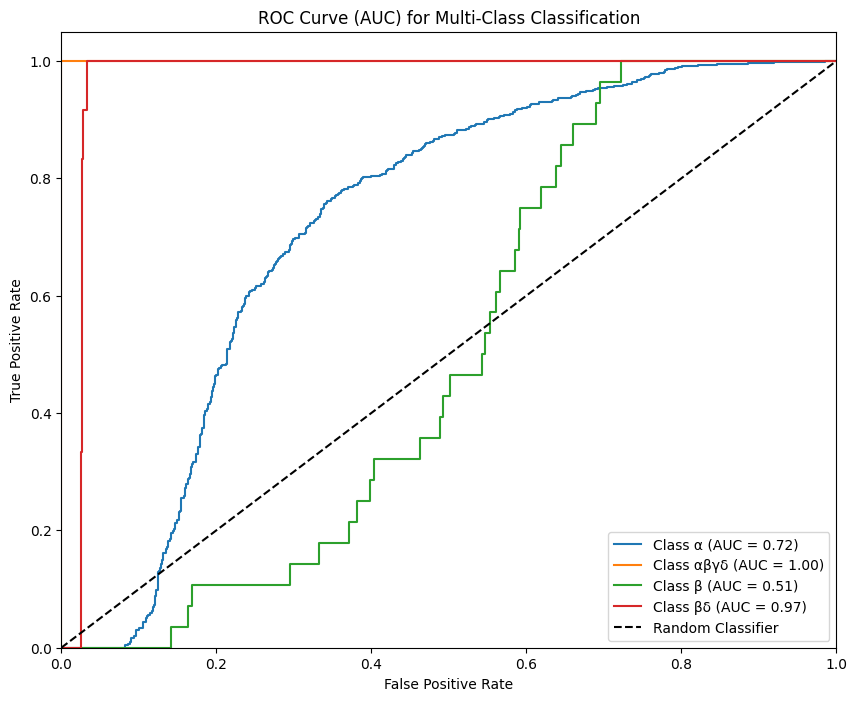

Predictions saved to r'D:\分类数据\感知机推理能力.xlsx


In [77]:
# import pandas as pd
# import numpy as np
# import torch
# from rdkit.Chem import MolFromSmiles, AllChem
# from rdkit.DataStructs import ConvertToNumpyArray
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import LabelBinarizer

# # 加载数据集
# data = pd.read_excel(r'D:\分类数据\0.1外部分类验证集.xlsx')

# # 定义亚型标签映射
# selective_map = {'α': 0, 'β': 1, 'γ': 2, 'δ': 3}
# non_selective_map = {
#     'βδ': [0, 1, 0, 1],
#     'αβγδ': [1, 1, 1, 1]
# }

# # SMILES 转分子描述符
# def smiles_to_fp(smiles):
#     mol = MolFromSmiles(smiles)
#     if mol is not None:
#         fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
#         arr = np.zeros((2048,), dtype=int)
#         ConvertToNumpyArray(fp, arr)
#         return arr
#     else:
#         return None

# # 批量处理 SMILES
# def batch_smiles_to_fp(smiles_list):
#     fps = []
#     valid_indices = []
#     for i, smile in enumerate(smiles_list):
#         fp = smiles_to_fp(smile)
#         if fp is not None:
#             fps.append(fp)
#             valid_indices.append(i)
#         else:
#             print(f"Invalid SMILES at index {i}: {smile}")
#     return np.array(fps), valid_indices

# # 提取 SMILES 并生成指纹
# smiles_list = data['smiles'].tolist()
# fps, valid_indices = batch_smiles_to_fp(smiles_list)

# # 标准化特征
# scaler = StandardScaler()
# fps_scaled = scaler.fit_transform(fps)

# # 转换为张量
# fps_tensor = torch.tensor(fps_scaled, dtype=torch.float32)

# # 模型推理
# model.eval()
# with torch.no_grad():
#     sel_out, multi_out = model(fps_tensor)
#     sel_pred = torch.argmax(sel_out, dim=1).numpy()
#     multi_pred = (multi_out.numpy() > 0.5).astype(int)

# # 构建预测结果并比对标签
# true_labels = []
# pred_labels = []
# results = []

# for i, idx in enumerate(valid_indices):
#     smile = smiles_list[idx]
#     true_label = data.iloc[idx]['labels']
    
#     # 模型预测
#     if sel_pred[i] < 4:  # 选择性抑制剂
#         predicted_label = list(selective_map.keys())[sel_pred[i]]
#     else:  # 非选择性抑制剂
#         predicted_label = ''.join([subtype for subtype, is_present in zip(['α', 'β', 'γ', 'δ'], multi_pred[i]) if is_present])
    
#     # 比对真实值和预测值
#     true_labels.append(true_label)
#     pred_labels.append(predicted_label)
    
#     results.append({
#         'SMILES': smile,
#         'True Label': true_label,
#         'Predicted Label': predicted_label,
#     })

# # 准确率
# accuracy = accuracy_score(true_labels, pred_labels)
# print(f"Overall Accuracy: {accuracy:.4f}")

# # 分类报告
# print("Classification Report:")
# print(classification_report(true_labels, pred_labels))

# # 混淆矩阵
# conf_matrix = confusion_matrix(true_labels, pred_labels)
# print("Confusion Matrix:")
# print(conf_matrix)

# # 绘制AUC曲线
# # 使用LabelBinarizer来处理多分类问题
# lb = LabelBinarizer()
# true_labels_bin = lb.fit_transform(true_labels)

# # 模型的预测概率（用于计算AUC）
# # multi_out 是每个类别的概率
# y_prob = multi_out.numpy()

# # 绘制ROC曲线
# plt.figure(figsize=(10, 8))
# n_classes = y_prob.shape[1]
# fpr, tpr, roc_auc = {}, {}, {}

# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], y_prob[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])
#     plt.plot(fpr[i], tpr[i], label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# # 画对角线（随机分类器的ROC曲线）
# plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# # 设置图形属性
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve (AUC) for Multi-Class Classification')
# plt.legend(loc='lower right')

# # 显示AUC曲线图
# plt.show()

# # 保存结果到 CSV 文件
# results_df = pd.DataFrame(results)
# results_df.to_excel(r'D:\分类数据\感知机推理能力.xlsx', index=False)

# print("Predictions saved to r'D:\分类数据\感知机推理能力.xlsx")


In [54]:
import pandas as pd
import numpy as np
import torch
from rdkit.Chem import AllChem, MolFromSmiles
from rdkit.DataStructs import ConvertToNumpyArray
from sklearn.preprocessing import StandardScaler
# 加载数据集（只包含smiles列）
input_file = r"D:\天然产物数据库\天然产物3-去空smiles.xlsx"  # 替换为您的文件路径
output_file = r"D:\天然产物的预测\多层感知机分类-天然产物3"  # 输出文件路径

# 读取Excel文件
data = pd.read_excel(input_file)

# SMILES 转分子描述符
def smiles_to_fp(smiles):
    mol = MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        arr = np.zeros((2048,), dtype=int)
        ConvertToNumpyArray(fp, arr)
        return arr
    else:
        return None

# 批量处理 SMILES
def batch_smiles_to_fp(smiles_list):
    fps = []
    valid_indices = []
    for i, smile in enumerate(smiles_list):
        fp = smiles_to_fp(smile)
        if fp is not None:
            fps.append(fp)
            valid_indices.append(i)
        else:
            print(f"Invalid SMILES at index {i}: {smile}")
    return np.array(fps), valid_indices

# 提取 SMILES 并生成指纹
smiles_list = data['smiles'].tolist()
fps, valid_indices = batch_smiles_to_fp(smiles_list)
# 标准化特征
scaler = StandardScaler()
fps_scaled = scaler.fit_transform(fps)
# 标准化特征
fps_scaled = scaler.transform(fps)  # 假设 scaler 已经被训练好

# 转换为张量
fps_tensor = torch.tensor(fps_scaled, dtype=torch.float32)

# 模型推理
model.eval()
with torch.no_grad():
    sel_out, multi_out = model(fps_tensor)
    sel_pred = torch.argmax(sel_out, dim=1).numpy()
    multi_pred = (multi_out.numpy() > 0.5).astype(int)

# 构建预测结果并保存
results = []
# 定义亚型标签映射
selective_map = {'α': 0, 'β': 1, 'γ': 2, 'δ': 3}
non_selective_map = {
    'βδ': [0, 1, 0, 1],
    'αβγδ': [1, 1, 1, 1]
}
for i, idx in enumerate(valid_indices):
    smile = smiles_list[idx]
    
    # 模型预测
    if sel_pred[i] < 4:  # 选择性抑制剂
        predicted_label = list(selective_map.keys())[sel_pred[i]]
    else:  # 非选择性抑制剂
        predicted_label = ''.join([subtype for subtype, is_present in zip(['α', 'β', 'γ', 'δ'], multi_pred[i]) if is_present])
    
    # 保存结果
    results.append({
        'SMILES': smile,
        'Predicted Label': predicted_label
    })

# 转为 DataFrame
results_df = pd.DataFrame(results)

# 保存结果到 Excel 文件
results_df.to_excel(output_file, index=False)

print(f"Predictions saved to {output_file}")


[00:18:12] DEPRECATION WARNING: please use MorganGenerator
[00:18:12] DEPRECATION WARNING: please use MorganGenerator
[00:18:12] DEPRECATION WARNING: please use MorganGenerator
[00:18:12] DEPRECATION WARNING: please use MorganGenerator
[00:18:12] DEPRECATION WARNING: please use MorganGenerator
[00:18:12] DEPRECATION WARNING: please use MorganGenerator
[00:18:12] DEPRECATION WARNING: please use MorganGenerator
[00:18:12] DEPRECATION WARNING: please use MorganGenerator
[00:18:12] DEPRECATION WARNING: please use MorganGenerator
[00:18:12] DEPRECATION WARNING: please use MorganGenerator
[00:18:12] DEPRECATION WARNING: please use MorganGenerator
[00:18:12] DEPRECATION WARNING: please use MorganGenerator
[00:18:12] DEPRECATION WARNING: please use MorganGenerator
[00:18:12] DEPRECATION WARNING: please use MorganGenerator
[00:18:12] DEPRECATION WARNING: please use MorganGenerator
[00:18:12] DEPRECATION WARNING: please use MorganGenerator
[00:18:12] DEPRECATION WARNING: please use MorganGenerat

ValueError: No engine for filetype: ''